# This notebook summarizes work on whole module to detect anomalies in unsupervised manner

In [1]:
from AutoAD import AutoAD

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.plot_data import plot_skab
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# Data from SKAB

In [3]:
path_to_data = 'datasets/raw/data/'

In [4]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))



# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

list_of_df = [df.drop(columns=['changepoint']) for df in list_of_df]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [5]:
import pickle

c = [
    ['HMM', [25, 'full', 200]],
    ['DENSEAE', [[16, 8, 16], 'elu', 'sigmoid', 0.1, 'rmsprop', 'mse']],
    ['CONVAE', [[(32, 7, 2), (16, 7, 1)], 'same', 'elu', 'adam', 'mae', 60]],
    ['LSTMAE', [[16, 8, 4], 'relu', 'rmsprop', 'mse', 16]],
    ['LSTMAE', [[16, 8, 6], 'elu', 'rmsprop', 'mse', 8]],
    ['LSTM', [[16, 8, 4], 'relu', 'rmsprop', 'mse', 8, 1]]
]

with open('config.pkl', 'wb') as f:
   pickle.dump(c, f)

## Using original data with known anomalies to model selection

### DF_0

STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


Model is not converging.  Current: 2232.0984557596353 is not greater than 2329.949761410406. Delta is -97.85130565077088
Model is not converging.  Current: 2360.554804674587 is not greater than 2422.358386317829. Delta is -61.80358164324207


Model #0	Score: -229.76161730874512
Model #1	Score: -357.2824797646983


Model is not converging.  Current: 1875.6170126313282 is not greater than 2006.49439326988. Delta is -130.8773806385518
Model is not converging.  Current: 2409.0221147714406 is not greater than 2489.9994409259566. Delta is -80.97732615451605


Model #2	Score: -168.70982178329794
Model #3	Score: -409.3520144270326


Model is not converging.  Current: 2598.4540213577516 is not greater than 2688.832016666608. Delta is -90.3779953088565


Model #4	Score: -349.8633789681207
11/11 [==============================] - 0s 1ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
21 12 176 536
FAR:  0.03770197486535009 MAR: 0.06382978723404255
0.9557046979865772 0.9142857142857144
<class 'models.HMM.HMM'> 7.536917300345798
24/24 [==============================] - 0s 822us/step
207 0 188 350
FAR:  0.37163375224416517 MAR: 0.0
24/24 [==============================] - 0s 724us/step
0.9106180111872876 0.7221476510067114 0.6449399656946827
<class 'models.DENSEAE.DenseAE'> 7.089996100282321
22/22 [==============================] - 0s 2ms/step
194 0 188 363
FAR:  0.348294434470377 MAR: 0.0
22/22 [==============================] - 0s 2ms/step
0.8544237391635291 0.7395973154362416 0.6596491228070176
<class 'models.CONVAE.ConvAE'> 7.071154170436581
23/23 [==============================] - 0s 3ms/step
106 4 184 451
FAR:  0.19030520646319568 MAR: 0.02127659574468085
23/23 [==============================] - 0s 3ms/step
0.7215312046405022 0.852348993

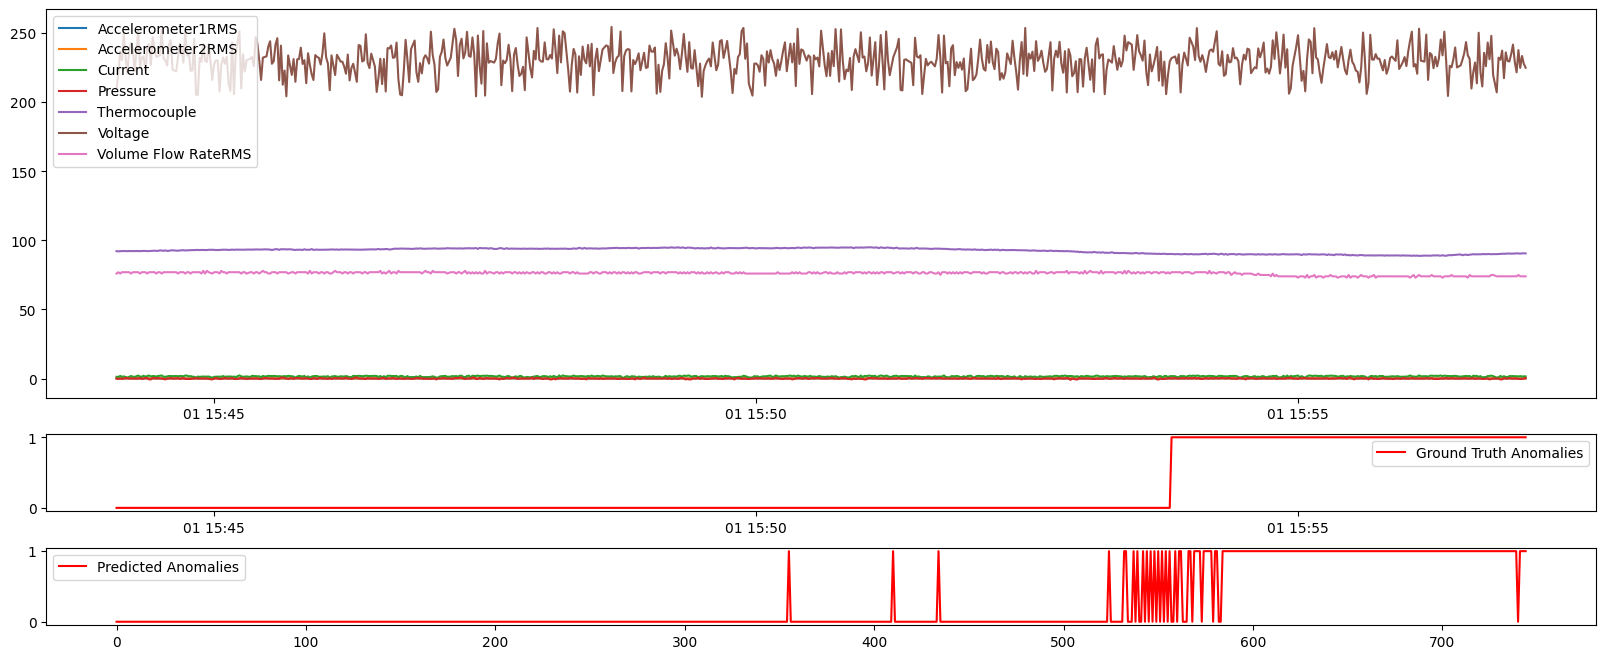

In [6]:
df = list_of_df[0]

detector = AutoAD(df[:400].drop(columns=['anomaly']), df.drop(columns=['anomaly']).values, df.anomaly.values)
detector.select_model()

anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']).values)
anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']).values)
anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']).values)

print(accuracy_score(anomalies, df.anomaly))
print(f1_score(anomalies, df.anomaly))

plot_skab(df.drop(columns=['anomaly']), df.anomaly, anomalies)

In [19]:
import numpy as np

from math import log
from scipy.optimize import minimize


def grimshaw(peaks:np.array, threshold:float, num_candidates:int=10, epsilon:float=1e-8):
    ''' The Grimshaw's Trick Method

    The trick of thr Grimshaw's procedure is to reduce the two variables 
    optimization problem to a signle variable equation. 

    Args:
        peaks: peak nodes from original dataset. 
        threshold: init threshold
        num_candidates: the maximum number of nodes we choose as candidates
        epsilon: numerical parameter to perform

    Returns:
        gamma: estimate
        sigma: estimate
    '''
    min = peaks.min()
    max = peaks.max()
    mean = peaks.mean()

    if abs(-1 / max) < 2 * epsilon:
        epsilon = abs(-1 / max) / num_candidates

    a = -1 / max + epsilon
    b = 2 * (mean - min) / (mean * min)
    c = 2 * (mean - min) / (min ** 2)

    candidate_gamma = solve(function=lambda t: function(peaks, threshold), 
                            dev_function=lambda t: dev_function(peaks, threshold), 
                            bounds=(a + epsilon, -epsilon), 
                            num_candidates=num_candidates
                            )
    candidate_sigma = solve(function=lambda t: function(peaks, threshold), 
                            dev_function=lambda t: dev_function(peaks, threshold), 
                            bounds=(b, c), 
                            num_candidates=num_candidates
                            )
    candidates = np.concatenate([candidate_gamma, candidate_sigma])

    gamma_best = 0
    sigma_best = mean
    log_likelihood_best = cal_log_likelihood(peaks, gamma_best, sigma_best)

    for candidate in candidates:
        gamma = np.log(1 + candidate * peaks).mean()
        sigma = gamma / candidate
        log_likelihood = cal_log_likelihood(peaks, gamma, sigma)
        if log_likelihood > log_likelihood_best:
            gamma_best = gamma
            sigma_best = sigma
            log_likelihood_best = log_likelihood

    return gamma_best, sigma_best


def function(x, threshold):
    s = 1 + threshold * x
    u = 1 + np.log(s).mean()
    v = np.mean(1 / s)
    return u * v - 1


def dev_function(x, threshold):
    s = 1 + threshold * x
    u = 1 + np.log(s).mean()
    v = np.mean(1 / s)
    dev_u = (1 / threshold) * (1 - v)
    dev_v = (1 / threshold) * (-v + np.mean(1 / s ** 2))
    return u * dev_v + v * dev_u


def obj_function(x, function, dev_function):
    m = 0
    n = np.zeros(x.shape)
    for index, item in enumerate(x):
        y = function(item)
        m = m + y ** 2
        n[index] = 2 * y * dev_function(item)
    return m, n


def solve(function, dev_function, bounds, num_candidates):
    step = (bounds[1] - bounds[0]) / (num_candidates + 1)
    x0 = np.arange(bounds[0] + step, bounds[1], step)
    optimization = minimize(lambda x: obj_function(x, function, dev_function), 
                            x0, 
                            method='L-BFGS-B', 
                            jac=True, 
                            bounds=[bounds]*len(x0)
                            )
    x = np.round(optimization.x, decimals=5)
    return np.unique(x)


def cal_log_likelihood(peaks, gamma, sigma):
    if gamma != 0:
        tau = gamma/sigma
        log_likelihood = -peaks.size * log(sigma) - (1 + (1 / gamma)) * (np.log(1 + tau * peaks)).sum()
    else: 
        log_likelihood = peaks.size * (1 + log(peaks.mean()))
    return log_likelihood

### DF_10

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


STARTING MODEL SELECTION PROCESS
MODEL GENERATION


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2210.0397229019527 is not greater than 2276.98813109483. Delta is -66.9484081928772


MODEL GENERATION COMPLETED
MODEL TRAINING
Model #0	Score: -31.77055372079501


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2456.02049306469 is not greater than 2504.0354623173707. Delta is -48.01496925268066
c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2236.5002253824096 is not greater than 2397.458659302446. Delta is -160.95843392003644
c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on W

Model #1	Score: -99.90091840816808
Model #2	Score: -215.96257875268557


Model is not converging.  Current: 2445.5381855582714 is not greater than 2481.5831881591844. Delta is -36.045002600912994
c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2162.0638474243774 is not greater than 2195.1419634164236. Delta is -33.07811599204615


Model #3	Score: -128.91714683375923
Model #4	Score: -195.55558231213777
11/11 [==============================] - 1s 2ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
15 113 289 730
FAR:  0.020134228187919462 MAR: 0.2810945273631841
0.8884045335658239 0.8186968838526912
<class 'models.HMM.HMM'> 6.811745323734823
36/36 [==============================] - 0s 778us/step
299 0 402 446
FAR:  0.40134228187919463 MAR: 0.0
36/36 [==============================] - 0s 696us/step
0.9110250814026205 0.7393199651264167 0.728921124206709
<class 'models.DENSEAE.DenseAE'> 7.216527812586686
34/34 [==============================] - 0s 2ms/step
315 0 402 430
FAR:  0.4228187919463087 MAR: 0.0
34/34 [==============================] - 0s 2ms/step
0.8552646713251747 0.7253705318221447 0.7184986595174263
<class 'models.CONVAE.ConvAE'> 7.027259609614729
36/36 [==============================] - 0s 3ms/step
293 0 402 452
FAR:  0.3932885906040268 MAR: 0.0
36/36 [==============================] - 0s 3ms/step
0.8055961

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


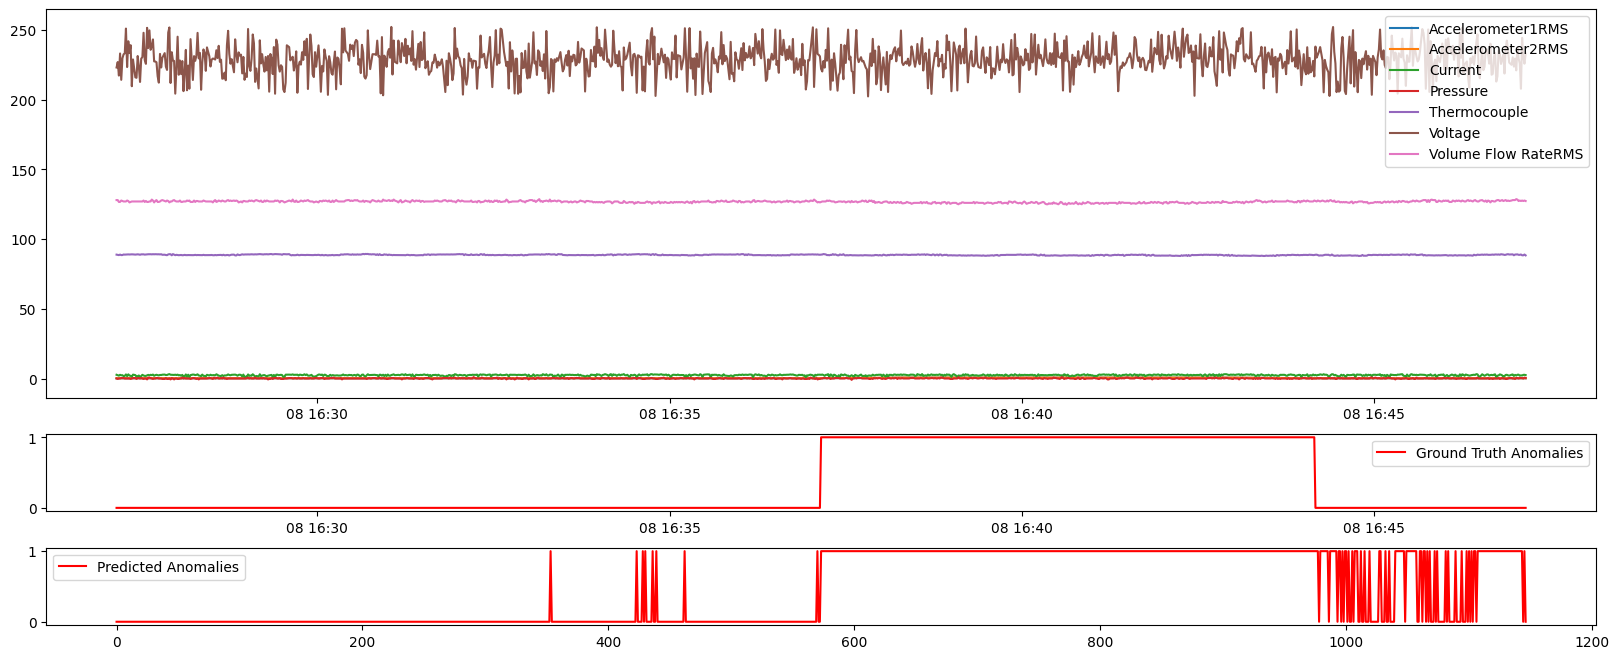

In [7]:
df = list_of_df[10]

detector = AutoAD(df[:400].drop(columns=['anomaly']), df.drop(columns=['anomaly']).values, df.anomaly.values)
detector.select_model()

anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']).values)

print(accuracy_score(anomalies, df.anomaly))
print(f1_score(anomalies, df.anomaly))

plot_skab(df.drop(columns=['anomaly']), df.anomaly, anomalies)

### DF_30

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


STARTING MODEL SELECTION PROCESS
MODEL GENERATION


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2282.055462574873 is not greater than 2428.4279998504567. Delta is -146.37253727558345


MODEL GENERATION COMPLETED
MODEL TRAINING
Model #0	Score: -176.23175582364846


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2211.522978294105 is not greater than 2288.4079262968594. Delta is -76.8849480027543
c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable O

Model #1	Score: -94.05267909098104
Model #2	Score: -203.02622105445946


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2001.6953925131043 is not greater than 2152.2232689673474. Delta is -150.52787645424314


Model #3	Score: -101.79353788888777
Model #4	Score: -54.23297645038977
11/11 [==============================] - 0s 2ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
72 169 225 659
FAR:  0.09849521203830369 MAR: 0.4289340101522843
0.7857777777777778 0.6512301013024603
<class 'models.HMM.HMM'> 5.8191573137793
36/36 [==============================] - 0s 756us/step
288 67 327 443
FAR:  0.39398084815321477 MAR: 0.1700507614213198
36/36 [==============================] - 0s 699us/step
0.8986538356356129 0.6844444444444444 0.6481665014866205
<class 'models.DENSEAE.DenseAE'> 6.650021899539842
34/34 [==============================] - 0s 2ms/step
313 19 375 418
FAR:  0.42818057455540354 MAR: 0.048223350253807105
34/34 [==============================] - 0s 2ms/step
0.8576677403637795 0.7048888888888889 0.6931608133086875
<class 'models.CONVAE.ConvAE'> 6.8537381466154015
35/35 [==============================] - 0s 4ms/step
304 44 350 427
FAR:  0.4158686730506156 MAR: 0.1116751269035533
35/35 [======

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0.7048888888888889
0.6931608133086875


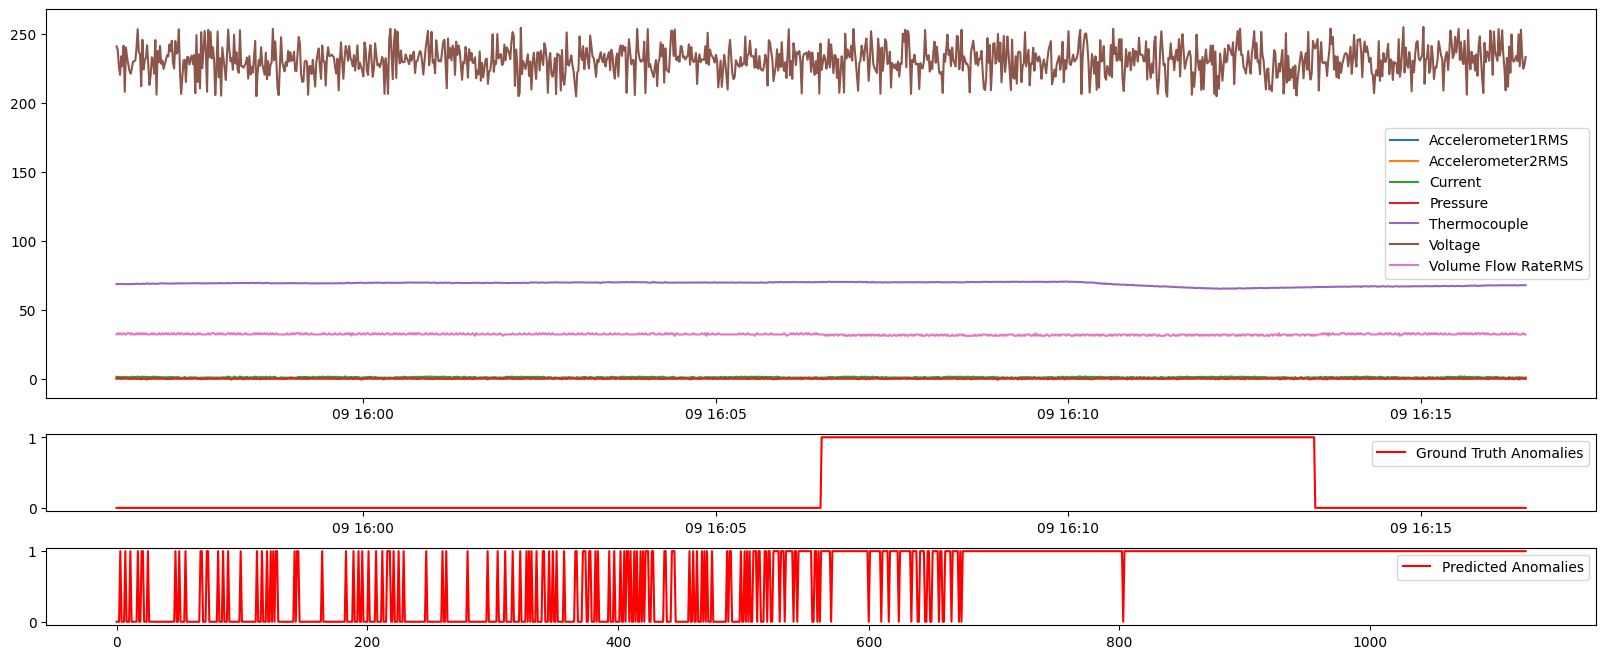

In [8]:
df = list_of_df[30]

detector = AutoAD(df[:400].drop(columns=['anomaly']), df.drop(columns=['anomaly']).values, df.anomaly.values)
detector.select_model()

anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']).values)

print(accuracy_score(anomalies, df.anomaly))
print(f1_score(anomalies, df.anomaly))

plot_skab(df.drop(columns=['anomaly']), df.anomaly, anomalies)

## Using original data modified by anomaly generator to model selection

### DF_0

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Model #0	Score: -307.89237352764167


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2617.290642751897 is not greater than 2675.576943067053. Delta is -58.28630031515604
c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2002.9634801970506 is not greater than 2128.7760199687077. Delta is -125.81253977165716


Model #1	Score: -273.6094316545212


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2243.2782869907855 is not greater than 2249.1238531002464. Delta is -5.845566109460833


Model #2	Score: -105.361731023814
Model #3	Score: -308.79591956801636


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Model is not converging.  Current: 2584.858216124837 is not greater than 2740.2916241767844. Delta is -155.43340805194748


Model #4	Score: -141.25264855462947
12/12 [==============================] - 0s 3ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
0.8088235294117647 0.7719298245614036
<class 'models.HMM.HMM'> 4.705366357069144
3/3 [==============================] - 0s 0s/step
0.9095648260354726 0.6911764705882353 0.746987951807229
<class 'models.DENSEAE.DenseAE'> 4.5886931038526235
2/2 [==============================] - 0s 0s/step
(68,) (68,)
0.8391826995118914 0.5 0.6666666666666666
<class 'models.CONVAE.ConvAE'> 4.005849366178558
2/2 [==============================] - 0s 4ms/step
(68,) (68,)
0.8241456055378931 0.5 0.6666666666666666
<class 'models.CONVAE.ConvAE'> 3.9908122722045594
2/2 [==============================] - 0s 8ms/step
(68,) (68,)
0.7249059637324105 0.7647058823529411 0.7419354838709677
<class 'models.LSTMAE.LstmAE'> 4.457353781569223
2/2 [==============================] - 0s 8ms/step
(68,) (68,)
0.7696335541902237 0.7205882352941176 0.7323943661971832
<class 'models.LSTMAE.LstmAE'> 4.419

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0.963758389261745
0.9302325581395349


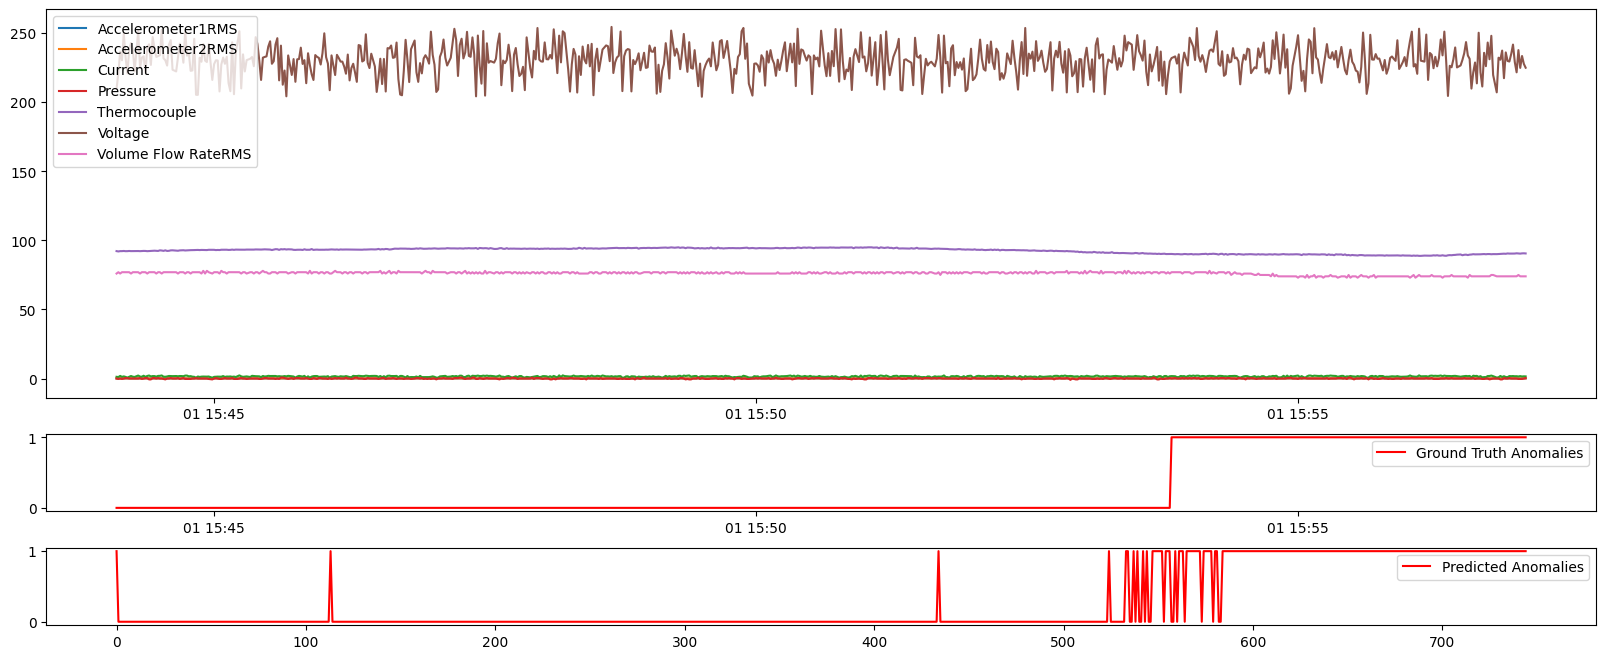

In [12]:
df = list_of_df[0]

detector = AutoAD(df[:450].drop(columns=['anomaly']))
detector.select_model()

anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']).values)

print(accuracy_score(anomalies, df.anomaly))
print(f1_score(anomalies, df.anomaly))

plot_skab(df.drop(columns=['anomaly']), df.anomaly, anomalies)

### DF_10

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


13/13 [==============================] - 0s 3ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
0.98 0.9183673469387755
<class 'models.HMM.HMM'> 5.6334693877551025
13/13 [==============================] - 0s 2ms/step
0.891599526391031 1.0 1.0
<class 'models.DENSEAE.DenseAE'> 5.8915995263910315
12/12 [==============================] - 0s 1ms/step
(400,) (400,)
0.8367336675285875 0.69 0.4464285714285714
<class 'models.CONVAE.ConvAE'> 3.3124479532428728
12/12 [==============================] - 0s 6ms/step
(400,) (400,)
0.6880736139351047 1.0 1.0
<class 'models.LSTMAE.LstmAE'> 5.688073613935105
13/13 [==============================] - 0s 2ms/step
(400,) (400,)
0.8215320579052083 0.9525 0.8403361344537814
<class 'models.LSTM.LstmPred'> 5.135376595720334
BEST MODEL SELECTED:  <class 'models.DENSEAE.DenseAE'>
36/36 [==============================] - 0s 955us/step
0.9110723626852659
0.8874172185430463


c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


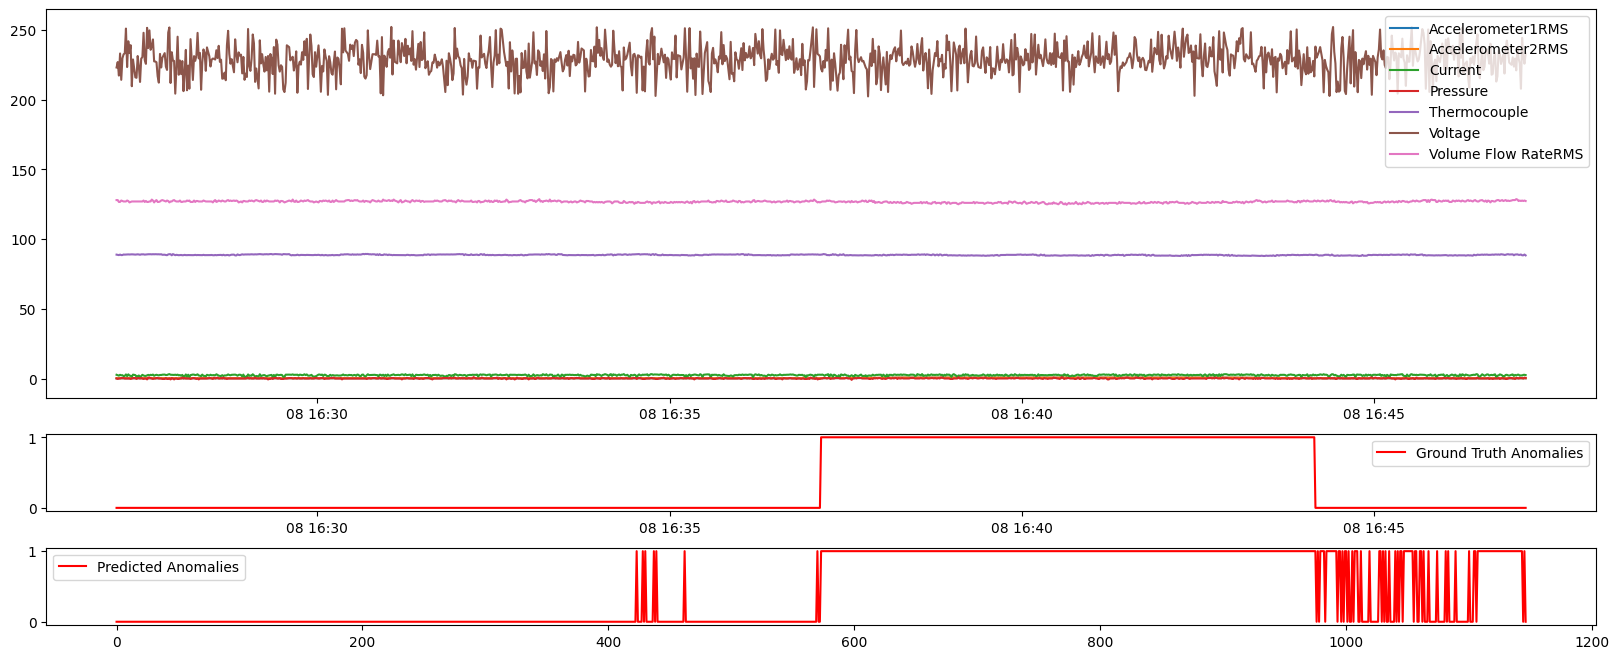

In [15]:
df = list_of_df[10]

detector = AutoAD(df[:400].drop(columns=['anomaly']))
detector.select_model()

anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']).values)

print(accuracy_score(anomalies, df.anomaly))
print(f1_score(anomalies, df.anomaly))

plot_skab(df.drop(columns=['anomaly']), df.anomaly, anomalies)

### DF_30

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


11/11 [==============================] - 0s 746us/step
MODEL TRAINING COMPLETED
MODEL SCORING
0.735 0.5619834710743802
<class 'models.HMM.HMM'> 3.717933884297521
13/13 [==============================] - 0s 1ms/step
0.8731559225266975 0.8025 0.639269406392694
<class 'models.DENSEAE.DenseAE'> 4.232733548097474
12/12 [==============================] - 0s 2ms/step
(400,) (400,)
0.8242824134372652 0.625 0.4827586206896552
<class 'models.CONVAE.ConvAE'> 3.380316896195886
12/12 [==============================] - 0s 6ms/step
(400,) (400,)
0.6761137029162472 0.995 0.9859154929577464
<class 'models.LSTMAE.LstmAE'> 5.614775674747232
13/13 [==============================] - 0s 2ms/step
(400,) (400,)
0.8175388380700354 0.7 0.5384615384615384
<class 'models.LSTM.LstmPred'> 3.671384991916189
BEST MODEL SELECTED:  <class 'models.LSTMAE.LstmAE'>
19/35 [===============>..............] - ETA: 0s

c:\Users\Marcin_Kosiba\anaconda3\envs\inz\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


35/35 [==============================] - 0s 6ms/step
0.7031111111111111
0.4014336917562724


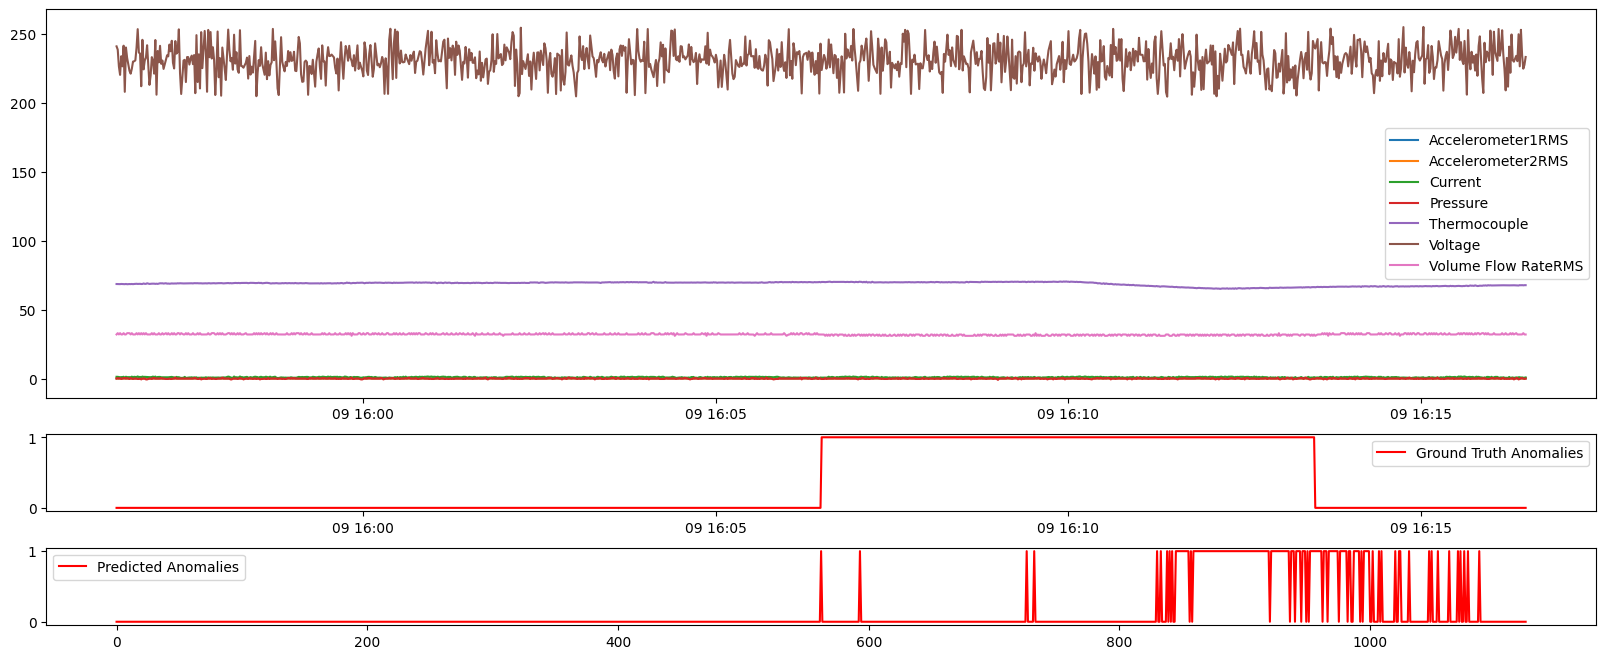

In [24]:
df = list_of_df[30]

detector = AutoAD(df[:400].drop(columns=['anomaly']))
detector.select_model()

anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']).values)

print(accuracy_score(anomalies, df.anomaly))
print(f1_score(anomalies, df.anomaly))

plot_skab(df.drop(columns=['anomaly']), df.anomaly, anomalies)

# SMD dataset

In [19]:
train_data = pd.read_csv('datasets/raw/ServerMachineDataset/train/machine-1-1.txt', header=None)
test_data = pd.read_csv('datasets/raw/ServerMachineDataset/test/machine-1-1.txt', header=None)
test_labels = pd.read_csv('datasets/raw/ServerMachineDataset/test_label/machine-1-1.txt', header=None)

## Basic models

In [8]:
import pickle

c = [
    ['HMM', [15, 'full', 100]],
    ['DENSEAE', [[38, 32, 16, 32, 38], 'elu', 'sigmoid', 0.1, 'rmsprop', 'mse']],
    ['CONVAE', [[(32, 7, 2), (16, 7, 2), (16, 7, 1)], 'same', 'elu', 'adam', 'mse', 32]],
    ['LSTMAE', [[32, 16, 8], 'relu', 'rmsprop', 'mse', 32]],
    ['LSTM', [[32, 16, 8], 'relu', 'rmsprop', 'mse', 10, 1]]
]

with open('config.pkl', 'wb') as f:
   pickle.dump(c, f)

In [9]:
detector = AutoAD(train_data, test_data, test_labels)
detector.select_model()

anomalies = detector.detect_anomalies(test_data)

print(accuracy_score(anomalies, test_labels))
print(f1_score(anomalies, test_labels))

STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


KeyboardInterrupt: 

In [ ]:
detector = AutoAD(train_data)
detector.select_model()

anomalies = detector.detect_anomalies(test_data)

print(accuracy_score(anomalies, test_labels))
print(f1_score(anomalies, test_labels))

STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


KeyboardInterrupt: 

## Adding more advanced models

In [20]:
import pickle

c = [
    ['HMM', [15, 'full', 150]],
    ['DENSEAE', [[38, 32, 16, 32, 38], 'elu', 'sigmoid', 0.1, 'rmsprop', 'mse']],
    ['CONVAE', [[(32, 7, 2), (16, 7, 2), (16, 7, 1)], 'same', 'elu', 'adam', 'mse', 32]],
    ['CONVAE', [[(64, 7, 2), (32, 7, 2), (32, 7, 1)], 'same', 'elu', 'adam', 'mse', 32]],
    ['LSTMAE', [[32, 16, 8], 'relu', 'rmsprop', 'mse', 32]],
    ['LSTMAE', [[64, 32, 16], 'relu', 'rmsprop', 'mse', 32]],
    ['LSTM', [[32, 16, 8], 'relu', 'rmsprop', 'mse', 10, 1]],
    ['LSTM', [[64, 32, 16], 'relu', 'rmsprop', 'mse', 10, 1]]
]

with open('config.pkl', 'wb') as f:
   pickle.dump(c, f)

In [21]:
detector = AutoAD(train_data, test_data, test_labels)
detector.select_model()

anomalies = detector.detect_anomalies(test_data)

print(accuracy_score(anomalies, test_labels))
print(f1_score(anomalies, test_labels))

STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


757/757 [==============================] - 4s 5ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
0.8920959303346325 0.4189827944791076
<class 'models.HMM.HMM'> 3.4601230385856954
890/890 [==============================] - 1s 670us/step
0.9797461146003674 0.3472032023596334 0.22469660953334164
<class 'models.DENSEAE.DenseAE'> 2.2257357550933676
889/889 [==============================] - 4s 4ms/step
(28479,) (28479, 1)
0.9853322442703937 0.35398012570666104 0.2265198015639452
<class 'models.CONVAE.ConvAE'> 2.2453915762328354
889/889 [==============================] - 6s 7ms/step
(28479,) (28479, 1)
0.9916627904935615 0.3914814424663787 0.23716876485606125
<class 'models.CONVAE.ConvAE'> 2.3318192923841856
889/889 [==============================] - 13s 14ms/step
(28479,) (28479, 1)
0.9722179657709049 0.36686681414375505 0.23006960160553394
<class 'models.LSTMAE.LstmAE'> 2.259363186336796
889/889 [==============================] - 19s 21ms/step
(28479,) (28479, 1)
0.9727994531915238 0.38322974

In [22]:
detector = AutoAD(train_data)
detector.select_model()

anomalies = detector.detect_anomalies(test_data)

print(accuracy_score(anomalies, test_labels))
print(f1_score(anomalies, test_labels))

STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


757/757 [==============================] - 6s 7ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
0.49976591760299627 0.0
<class 'models.HMM.HMM'> 0.9995318352059925
134/134 [==============================] - 0s 894us/step
0.9802828762660234 0.5969101123595506 0.5653710247349822
<class 'models.DENSEAE.DenseAE'> 3.838677087565503
133/133 [==============================] - 1s 10ms/step
(4272,) (4272,)
0.9847720318762113 0.6200842696629213 0.6295366354713536
<class 'models.CONVAE.ConvAE'> 4.123002843424548
133/133 [==============================] - 2s 12ms/step
(4272,) (4272,)
0.9857030231498188 0.6306179775280899 0.6418520199727644
<class 'models.CONVAE.ConvAE'> 4.183729080568966
133/133 [==============================] - 3s 23ms/step
(4272,) (4272,)
0.9754771349966306 0.5646067415730337 0.47516930022573367
<class 'models.LSTMAE.LstmAE'> 3.440761077472599
133/133 [==============================] - 5s 35ms/step
(4272,) (4272,)
0.9734402631250036 0.5526685393258427 0.45164992826398853
<class '

# ECG

In [9]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [10]:
df.shape

(4998, 141)

In [11]:
labels = df.iloc[:, -1]
data = df.iloc[:, :-1]

In [12]:
data.shape

(4998, 140)

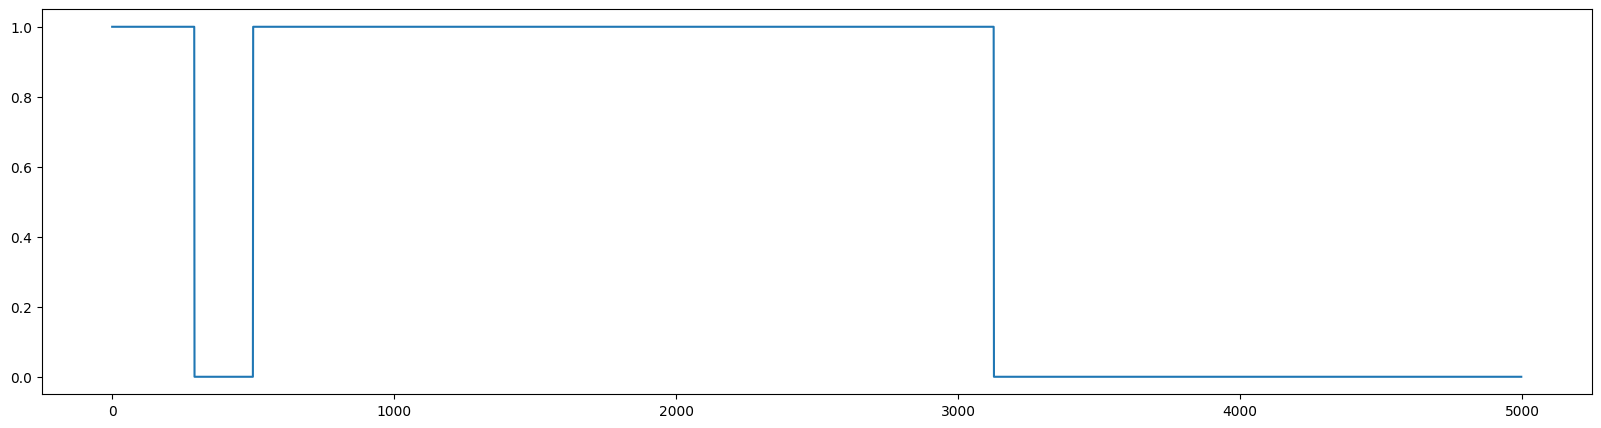

In [13]:
plt.figure(figsize=(20,5))
plt.plot(labels)
plt.show()

In [14]:
np.unique(labels[3150:])

array([0.])

In [15]:
train_data = data.iloc[3150:, :]

In [16]:
import pickle

c = [
    #['HMM', [15, 'full', 150]],
    ['DENSEAE', [[140, 32, 16, 32, 140], 'relu', 'sigmoid', 0.1, 'rmsprop', 'mse']],
    #['CONVAE', [[(32, 7, 2), (16, 7, 2), (16, 7, 1)], 'same', 'elu', 'adam', 'mse', 32]],
    ['CONVAE', [[(64, 7, 2), (32, 7, 2), (32, 7, 1)], 'same', 'elu', 'adam', 'mse', 32]],
    #['LSTMAE', [[32, 16, 8], 'relu', 'rmsprop', 'mse', 32]],
    ['LSTMAE', [[64, 32, 16], 'relu', 'rmsprop', 'mse', 32]],
    #['LSTM', [[32, 16, 8], 'relu', 'rmsprop', 'mse', 10, 1]],
    ['LSTM', [[64, 32, 16], 'relu', 'rmsprop', 'mse', 10, 1]]
]

with open('config.pkl', 'wb') as f:
   pickle.dump(c, f)

In [17]:
detector = AutoAD(train_data, data, labels)
detector.select_model()

anomalies = detector.detect_anomalies(data)

print(accuracy_score(anomalies, labels))
print(f1_score(anomalies, labels))

STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING
49/49 [==============================] - 0s 3ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
157/157 [==============================] - 0s 601us/step
279 15 2904 1800
FAR:  0.1341991341991342 MAR: 0.0051387461459403904
157/157 [==============================] - 0s 591us/step
0.9484827493158048 0.9411764705882353 0.951819075712881
<class 'models.DENSEAE.DenseAE'> 8.463104359955459
156/156 [==============================] - 1s 5ms/step
211 4 2915 1868
FAR:  0.10149110149110149 MAR: 0.0013703323055841042
156/156 [==============================] - 1s 5ms/step
0.9521153842269471 0.9569827931172469 0.9644334160463192
<class 'models.CONVAE.ConvAE'> 8.584357526070407
156/156 [==============================] - 2s 15ms/step
340 263 2656 1739
FAR:  0.16354016354016354 MAR: 0.09009934909215485
156/156 [==============================] - 2s 14ms/step
0.9330750408983857 0.8793517406962785 0.8980557903634827
<cl

In [ ]:
detector = AutoAD(train_data)
detector.select_model()

anomalies = detector.detect_anomalies(data)

print(accuracy_score(anomalies, labels))
print(f1_score(anomalies, labels))

In [55]:
train_data = data[labels==0]

In [56]:
detector = AutoAD(train_data, data, labels)
detector.select_model()

anomalies = detector.detect_anomalies(data)

print(accuracy_score(anomalies, labels))
print(f1_score(anomalies, labels))

STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING
56/56 [==============================] - 0s 2ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
157/157 [==============================] - 0s 1ms/step
0.955980426181452 0.41616646658663464 0.0006849315068493151
<class 'models.DENSEAE.DenseAE'> 1.374886618795484
BEST MODEL SELECTED:  <class 'models.DENSEAE.DenseAE'>
157/157 [==============================] - 0s 1ms/step
0.4257703081232493
0.05654174884944115


In [ ]:
detector = AutoAD(train_data)
detector.select_model()

anomalies = detector.detect_anomalies(data)

print(accuracy_score(anomalies, labels))
print(f1_score(anomalies, labels))

# MBA Dataset

In [27]:
train_data = pd.read_excel('datasets/raw/MBA/train.xlsx').iloc[1:, 1:].reset_index().iloc[:, 1:]
test_data = pd.read_excel('datasets/raw/MBA/test.xlsx').iloc[1:, 1:].reset_index().iloc[:, 1:]
labels = pd.read_excel('datasets/raw/MBA/labels.xlsx')

In [30]:
labels = labels['Sample']

In [40]:
anomalies = [0] * test_data.shape[0]
for x in labels:
    anomalies[x] = 1

In [41]:
labels = np.array(anomalies)

In [48]:
import pickle

c = [
    ['HMM', [15, 'full', 150]],
    ['DENSEAE', [[2, 32, 16, 32, 2], 'relu', 'sigmoid', 0.1, 'rmsprop', 'mse']],
    ['CONVAE', [[(32, 7, 2), (16, 7, 2), (16, 7, 1)], 'same', 'elu', 'adam', 'mse', 32]],
    ['CONVAE', [[(64, 7, 2), (32, 7, 2), (32, 7, 1)], 'same', 'elu', 'adam', 'mse', 32]],
    #['LSTMAE', [[32, 16, 8], 'relu', 'rmsprop', 'mse', 32]],
    ['LSTMAE', [[64, 32, 16], 'relu', 'rmsprop', 'mse', 32]],
    ['LSTM', [[16, 8], 'relu', 'rmsprop', 'mse', 10, 1]],
    ['LSTM', [[64, 32, 16], 'relu', 'rmsprop', 'mse', 10, 1]]
]

with open('config.pkl', 'wb') as f:
   pickle.dump(c, f)

In [49]:
detector = AutoAD(train_data, test_data, labels)
detector.select_model()

anomalies = detector.detect_anomalies(test_data)

print(accuracy_score(anomalies, labels))
print(f1_score(anomalies, labels))

STARTING MODEL SELECTION PROCESS
MODEL GENERATION
MODEL GENERATION COMPLETED
MODEL TRAINING


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


204/204 [==============================] - 1s 4ms/step
MODEL TRAINING COMPLETED
MODEL SCORING
0.9942708333333333 0.0
<class 'models.HMM.HMM'> 1.9885416666666667
240/240 [==============================] - 0s 831us/step
0.9511076821210245 0.9248697916666667 0.0
<class 'models.DENSEAE.DenseAE'> 1.875977473787691
240/240 [==============================] - 1s 2ms/step
(7680,) (7680,)
0.9887456882048417 0.8822916666666667 0.0
<class 'models.CONVAE.ConvAE'> 1.8710373548715085
240/240 [==============================] - 1s 3ms/step
(7680,) (7680,)
0.9803312624393731 0.92109375 0.0
<class 'models.CONVAE.ConvAE'> 1.9014250124393732
240/240 [==============================] - 4s 16ms/step
(7680,) (7680,)
0.9433860122965467 0.8861979166666667 0.0
<class 'models.LSTMAE.LstmAE'> 1.8295839289632134
240/240 [==============================] - 1s 2ms/step
(7680,) (7680,)
0.9718756400382961 0.9235677083333333 0.0
<class 'models.LSTM.LstmPred'> 1.8954433483716295
240/240 [==============================] - 1

In [45]:
anos = detector.detect_anomalies(test_data)

  1/240 [..............................] - ETA: 3s

240/240 [==============================] - 0s 1ms/step


In [46]:
np.unique(anos)

array([0, 1])